In [3]:
#import numpy as np
import math
import autograd.numpy as np
from autograd import grad

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [4]:
# load cifar-10-small and project down
 
def unpickle( file ):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict
 
data = unpickle( './cifar-10-batches-py/data_batch_1' )
 
X_matrix = data['data']
t_vector = data['labels']
t_vector = np.atleast_2d(t_vector).T
 
N = 1000
D = 10

ROWS_AXIS = 0
COLS_AXIS = 1
 
# only keep N items
X_matrix = X_matrix[ 0:N, : ] 
t_vector = t_vector[ 0:N, : ]
 
# project down into a D-dimensional space
#X_matrix = np.dot( X_matrix, np.random.randn( 3072, D) )
 
# whiten our data - zero mean and unit standard deviation
X_matrix = (X_matrix - np.mean(X_matrix, axis=0)) / np.std(X_matrix, axis=0)

# Adding bias
data = pd.DataFrame(X_matrix)
data.insert(0, "BIAS", np.ones(len(data)))
X_matrix = data.values

# Defining some constants
DATASET_LENGTH = X_matrix.shape[0] # rows
FEATURES_LENGTH = X_matrix.shape[1] # columns
CLASSES_LENGTH = 10
LEARNING_RATE = 0.1
EPOCHS = 2000

# Initializing Weight matrix
W_matrix = np.random.randn(FEATURES_LENGTH, CLASSES_LENGTH)

In [5]:
# Plotting section

# x and y coordinates to plot 
x_coordinates = np.linspace(0, EPOCHS, num=EPOCHS)
loss_y_coordinates = np.zeros(EPOCHS)
accuracy_y_coordinates = np.zeros(EPOCHS)


def plot(x, y, limits, title, x_label_name, y_label_name):
    plt.close("all")
    figure = plt.figure()
    figure.clf()
    
    plt.plot(x, y)
    
    #plt.axis(limits)
    plt.ylabel(y_label_name)
    plt.xlabel(x_label_name)

    figure.suptitle(title, fontsize=20)
    plt.legend(loc='upper right')
    
    plt.show()
    return


def plot_loss():
    limits = [0,EPOCHS,0,5]
    plot(x_coordinates, loss_y_coordinates, limits, "Loss Overtime", "Epochs", "Loss")  
    return
    
    
def plot_accuracy():
    limits = [0,EPOCHS,0,1]
    plot(x_coordinates, accuracy_y_coordinates, limits, "Accuracy Overtime", "Epochs", "Accuracy")
    return

In [6]:
# X_matris is the feature matrix 1000 images by 11 features. 10 features + bias
# W_matrix is the weigth matrix 11 features by 10 classes
# S_matrix is the score matrix 1000 images by 10 classes
def scores(X_matrix, W_matrix):
    #print("X_matrix " + str(X_matrix.shape))
    #print("W_matrix " + str(W_matrix.shape))
    S_matrix = np.dot(X_matrix, W_matrix)
    #print("S_matrix " + str(S_matrix.shape))
    return S_matrix

In [7]:
# S_matrix is the score matrix 1000 images by 10 classes
# E_matrix is the exp score matrix 1000 images by 10 classes
# P_matrix is the probability matrix 1000 images by 10 classes. Every row adds to 1
def softmax(S_matrix): 
    # Exp-normalize trick to avoid numerical overflow
    S_matrix = S_matrix - np.max(S_matrix) 
    #print("S_matrix " + str(S_matrix.shape))
    E_matrix = np.exp(S_matrix)
    #print("E_matrix " + str(E_matrix.shape))
    P_matrix = E_matrix / np.sum(E_matrix, axis=ROWS_AXIS, keepdims=True) 
    #print("P_matrix " + str(P_matrix))
    #print("P_matrix " + str(P_matrix.shape))
    #print("p_vector " + str(np.sum(P_matrix, axis=0)))
    return P_matrix

In [8]:
# P_matrix is the probability matrix 1000 images by 10 classes. Every row adds to 1
# L_matrix is the loss matrix 1000 images by 10 classes
def cross_entropy(P_matrix):
    #print("P_matrix " + str(P_matrix.shape))
    L_matrix = -np.log(P_matrix)  
    #print("L_matrix " + str(L_matrix.shape))
    return L_matrix

In [9]:
# L_matrix is the loss matrix 1000 images by 10 classes
# t_vector is the target vector 1000 images by 1 label
# l_vector is the vector that holds the loss quantities of the right classes 1000 images by 1 loss
# l_scalar is the overall loss. It is the mean of the l_vector
def loss(L_matrix, t_vector):
    ROWS = np.arange(0,DATASET_LENGTH,1).reshape(DATASET_LENGTH,1)
    #print("rows " + str(ROWS.shape))
    COLS = t_vector
    #print("cols " + str(COLS.shape))
    l_vector = L_matrix[ROWS, COLS] # this is just grabbing the correct classes to make a vector 
    #print("l_vector " + str(l_vector.shape))
    l_scalar = np.mean(l_vector) 
    #print("l_scalar " + str(type(l_scalar)))
    return l_scalar

In [10]:
# loss function receives the weights matrix and outputs the
# overall loss of this weigths matrix
def loss_function(W_matrix):
    S_matrix = scores(X_matrix, W_matrix)
    P_matrix = softmax(S_matrix)
    L_matrix = cross_entropy(P_matrix)
    l_scalar = loss(L_matrix, t_vector)
    return l_scalar

In [11]:
# S_matrix is the score matrix 1000 images by 10 classes
# t_vector is the target vector 1000 images by 1 label
# p_vector is the predicted vector 1000 images by 1 prediction
# a_vector is the accuracy vector 1000 images by 1 match
# a_scalar is the mean of the accuracy vector
def accuracy(S_matrix, t_vector):
    #t_vector = np.atleast_2d(t_vector)
    #print(S_matrix.shape)
    p_vector = np.argmax(S_matrix, axis=COLS_AXIS).reshape(DATASET_LENGTH, 1)
    #print(p_vector.shape)
    #print(t_vector.shape)
    a_vector = p_vector == t_vector
    #print(a_vector.shape)
    a_scalar = np.mean(a_vector)
    #print(a_scalar)
    return a_scalar

In [12]:
# general definition of the derivative
# ( f(x + h) - f(x) ) / h
#
# In this particular implementation
# function is the loss function
# X_matrix is the weight matrix
# fx_scalar is the loss for that weight matrix
# 
# Xh_matrix is the weight vector plus h at the current row and col
# fxh_scalar is the loss of this new weight matrix
# G_matrix[row,col] = (fxh_scalar - fx_scalar) / h_scalar  is the partial derivative

h_scalar = 0.000001

def gradient(function, X_matrix):
    # Initializing a gradient matrix
    G_matrix = np.zeros_like(X_matrix)
    
    # computing f(x)
    fx_scalar = function(X_matrix)
    
    # getting ready for computing partial derivatives one row-col pair at a time
    for col in range(X_matrix.shape[COLS_AXIS]):
        for row in range(X_matrix.shape[ROWS_AXIS]):
            
            # adding h to one square in the new x matrix
            Xh_matrix = X_matrix
            Xh_matrix[row, col] = Xh_matrix[row, col] + h_scalar
            
            # computing f(x+h)
            fxh_scalar = function(Xh_matrix)
            
            # partial derivative is the derivative of a function  
            # with respect to one variable, while treating the other variables as constants
            partial_derivative = (fxh_scalar - fx_scalar) / h_scalar 
            
            # saving this partial derivative in it corresponding place of the
            # gradient matrix
            G_matrix[row, col] = partial_derivative
        
    return G_matrix

In [13]:
automatic_gradient = grad(loss_function)

In [14]:
# Learning section
for epoch in range(EPOCHS):
    
    # Shuffling features and labels to help learning
    #X_matrix, t_vector = shuffle(X_matrix, t_vector, random_state=0)
    
    # Feed forward phase
    S_matrix = scores(X_matrix, W_matrix)
    P_matrix = softmax(S_matrix)
    L_matrix = cross_entropy(P_matrix)
    
    # Getting numbers for plotting
    l_scalar = loss(L_matrix, t_vector)
    a_scalar = accuracy(S_matrix, t_vector)
    
    # Getting gradient and updating weigths 
    G_matrix = automatic_gradient(W_matrix)
    W_matrix = W_matrix - ( LEARNING_RATE * G_matrix )
    
    # Updating y coordinates for plotting
    loss_y_coordinates[epoch] = l_scalar
    accuracy_y_coordinates[epoch] = a_scalar
    #break
    


/home/isai/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


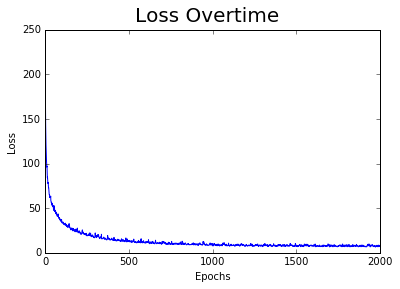

In [15]:
plot_loss()

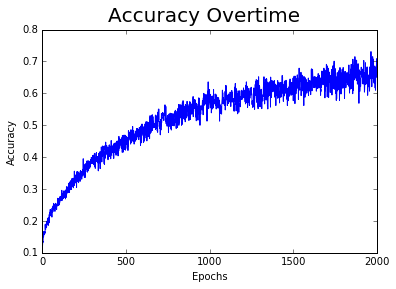

In [16]:
plot_accuracy()